In [54]:
%load_ext autoreload
%autoreload 2

from typing import List, Dict

import os
import sys
import yaml
sys.path.append('..')

import time
from tqdm import tqdm
from pathlib import Path

import numpy as np
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datasets
from ml_collections.config_dict import ConfigDict

import jgnn_utils as jgnn_ut

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# Read in the generated dataset
# dataset_name = 'wdm/lyric-dawn-74'
dataset_root = "/mnt/ceph/users/tnguyen/dark_camels/point-cloud-diffusion-outputs"
# dataset_name = 'vdm-flows/dazzling-leaf-75_earthy-dream-105'
dataset_name = 'vdm/dazzling-leaf-75'
dataset_path = os.path.join(dataset_root, f'{dataset_name}.npz')

dataset = np.load(dataset_path)
gen_samples = dataset['samples']
cond = dataset['cond']
mask = dataset['mask']
truth_samples = dataset['truth']
truth_mask = dataset.get('truth_mask', mask)

num_samples = gen_samples.shape[0]
num_cond = cond.shape[1]

# apply mask 
gen_samples = gen_samples * mask[..., None]
truth_samples = truth_samples * truth_mask[..., None]
gen_samples[gen_samples == 0] = np.nan
truth_samples[truth_samples == 0] = np.nan

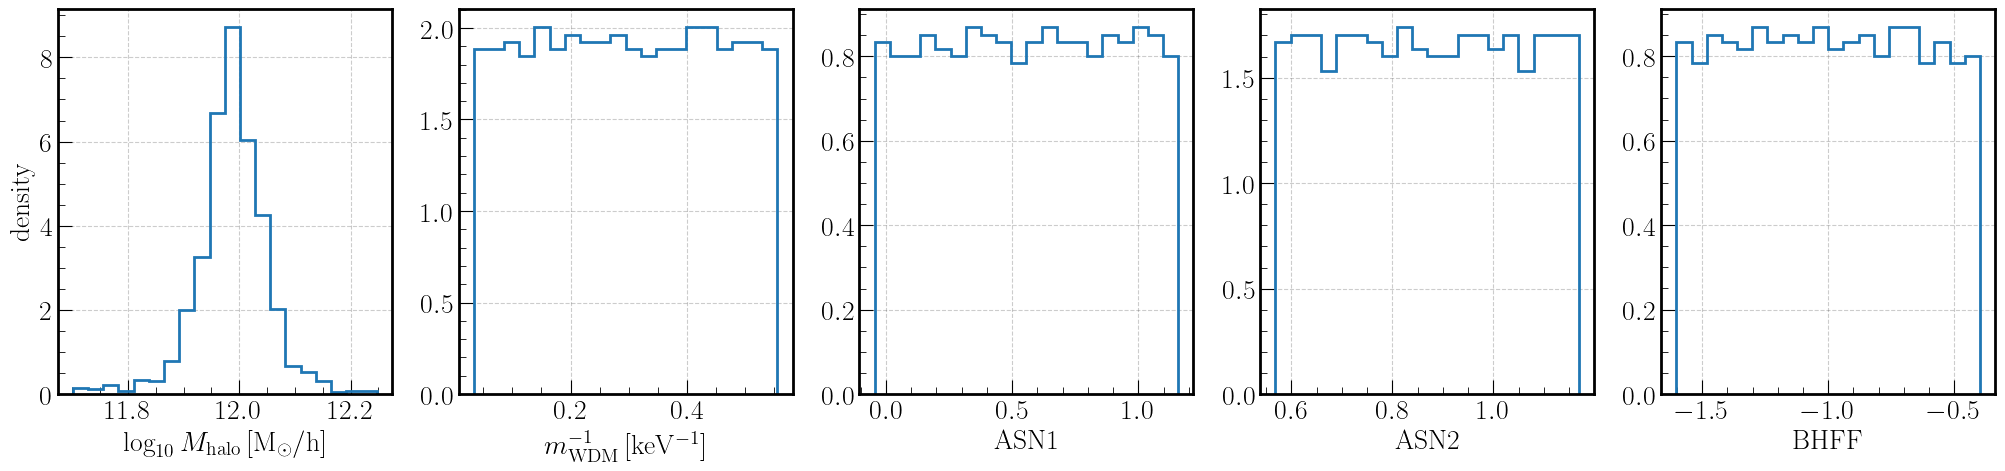

In [68]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    axes[i].hist(cond[:, i], bins=20, 
    histtype='step', lw=2, density=True)

axes[0].set_xlabel(r'$\log_{10} M_\mathrm{halo} \, [\rm M_\odot / h]$')
axes[1].set_xlabel(r'$m^{-1}_\mathrm{WDM} \, [\rm keV^{-1}]$')
axes[2].set_xlabel(r'ASN1')
axes[3].set_xlabel(r'ASN2')
axes[4].set_xlabel(r'BHFF')
axes[0].set_ylabel(r'density')

plt.show()
fig.tight_layout()

## Binned analysis of the Sobol parameters

In [69]:
# bin the data by the number of conditional parameters
n_bins_per_dim = 5
n_bins = n_bins_per_dim**num_cond
cond_min = cond.min(axis=0)
cond_max = cond.max(axis=0)
bin_edges = [np.linspace(cond_min[i], cond_max[i], n_bins_per_dim + 1) for i in range(num_cond)]

# get the bin indices along each dimension
indices = [np.digitize(cond[:, i], bin_edges[i]) - 1 for i in range(num_cond)]

In [70]:
def get_bins(indices, select):
    """ Return the bin mask for a given selection. """
    mask = np.ones(indices[0].shape, dtype=bool)
    for i, s in zip(indices, select):
        if s is not None:
            mask &= i == s
    return mask

def get_histogram_q(samples, bins, q, cumulative=False, normalized=False):
    """ Compute the qth percentile of a samples of histograms. """
    counts = [np.histogram(samples[i], bins=bins)[0] for i in range(samples.shape[0])]
    counts = np.stack(counts, axis=0)
    if normalized:
        counts = counts / counts.sum(1, keepdims=True)
    if cumulative:
        counts = counts.sum(1, keepdims=True) - np.cumsum(counts, axis=1)

    counts_q = np.nanpercentile(counts, q=q, axis=0)
    return counts_q

In [71]:
gen_samples_bins = []
truth_samples_bins = []
mask_bins = []
cond_bins = []

for i in range(n_bins_per_dim):
    # select = [None, i, 0, 0, 0]
    select = [None, i, None, None, None]
    bin_mask = get_bins(indices, select)
    gen_samples_bins.append(gen_samples[bin_mask])
    truth_samples_bins.append(truth_samples[bin_mask])
    mask_bins.append(mask[bin_mask])
    cond_bins.append(cond[bin_mask])

19200
19800
19400
19800
19300


(-1.0, 60.0)

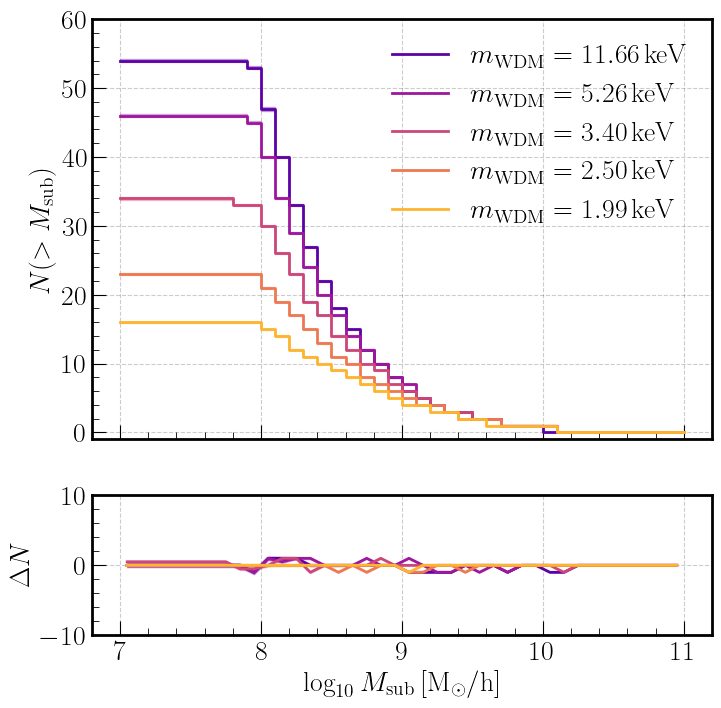

In [72]:
# define the bin for the subhalo mass function
x_bin_size = 0.1
x_plot_range = (7, 11)
x_q = [50, 16, 84]
x_cumulative = True
x_bins = np.arange(x_plot_range[0], x_plot_range[1] + x_bin_size, x_bin_size)
x_num_bins = len(x_bins) - 1
x_bins_center = 0.5 * (x_bins[:-1] + x_bins[1:])
x_bins_plot = np.zeros(2 * x_num_bins)
x_bins_plot[::2] = x_bins[:-1]
x_bins_plot[1::2] = x_bins[1:]

fig, axes = plt.subplots(
    2, 1, figsize=(8, 8), sharex=True, sharey='row', 
    gridspec_kw=dict(height_ratios=[3, 1]))

colors = sns.color_palette('plasma', n_bins_per_dim)

for i in range(n_bins_per_dim):
    label = r'$m_\mathrm{{WDM}} = {{{:.2f}}} \, \mathrm{{keV}}$'.format(
        1/np.mean(cond_bins[i][:, 1]))

    # calculate the median and 1-sigma error bars
    num_samples_bins = gen_samples_bins[i].shape[0]
    print(num_samples_bins)
    gen_x_med, gen_x_low, gen_x_high = get_histogram_q(
        gen_samples_bins[i][..., 6], bins=x_bins, q=x_q, cumulative=True)
    gen_x_err = (gen_x_high - gen_x_low) / np.sqrt(num_samples_bins)
    gen_x_low_std = gen_x_med - gen_x_err
    gen_x_high_std = gen_x_med + gen_x_err

    truth_x_counts = get_histogram_q(
        truth_samples_bins[i][..., 6], bins=x_bins, q=x_q, cumulative=True)
    diff_x_counts = gen_x_med - truth_x_counts[0]

    axes[0].plot(
        x_bins_plot, gen_x_med.repeat(2), lw=2, color=colors[i], 
        label=label)
    axes[0].fill_between(
        x_bins_plot, gen_x_low_std.repeat(2), gen_x_high_std.repeat(2),
        color=colors[i], alpha=0.3)

    axes[1].plot(
        x_bins_center, diff_x_counts, lw=2, color=colors[i])
    axes[1].fill_between(
        x_bins_center, diff_x_counts - gen_x_err, diff_x_counts + gen_x_err,
        color=colors[i], alpha=0.3)

axes[1].set_xlabel(r'$\log_{10} M_\mathrm{sub} \, [\rm M_\odot / h]$')

axes[0].set_ylabel(r'$N(> M_\mathrm{sub})$')
axes[1].set_ylabel(r'$\Delta N$')
axes[0].legend(fontsize=20)
axes[1].set_ylim(-10, 10)
axes[0].set_ylim(-1, 60)

# fig.subplots_adjust(hspace=0.05, wspace=0.05)
# fig.savefig('figures/msubhalo_mWDM.png', bbox_inches='tight')
# plt.show()

(-1.0, 60.0)

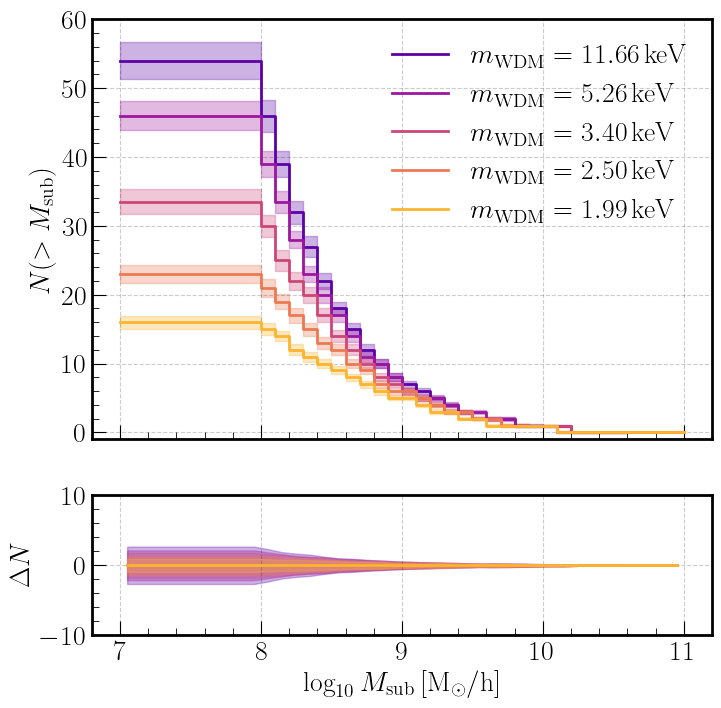

In [73]:
# define the bin for the subhalo mass function
x_bin_size = 0.1
x_plot_range = (7, 11)
x_q = [50, 16, 84]
x_cumulative = True
x_bins = np.arange(x_plot_range[0], x_plot_range[1] + x_bin_size, x_bin_size)
x_num_bins = len(x_bins) - 1
x_bins_center = 0.5 * (x_bins[:-1] + x_bins[1:])
x_bins_plot = np.zeros(2 * x_num_bins)
x_bins_plot[::2] = x_bins[:-1]
x_bins_plot[1::2] = x_bins[1:]

fig, axes = plt.subplots(
    2, 1, figsize=(8, 8), sharex=True, sharey='row', 
    gridspec_kw=dict(height_ratios=[3, 1]))

colors = sns.color_palette('plasma', n_bins_per_dim)

for i in range(n_bins_per_dim):
    label = r'$m_\mathrm{{WDM}} = {{{:.2f}}} \, \mathrm{{keV}}$'.format(
        1/np.mean(cond_bins[i][:, 1]))

    # calculate the median and 1-sigma error bars
    num_samples_bins = truth_samples_bins[i].shape[0]
    gen_x_med, gen_x_low, gen_x_high = get_histogram_q(
        truth_samples_bins[i][..., 6], bins=x_bins, q=x_q, cumulative=True)
    gen_x_err = (gen_x_high - gen_x_low) / np.sqrt(num_samples_bins/100)
    gen_x_low_std = gen_x_med - gen_x_err
    gen_x_high_std = gen_x_med + gen_x_err

    truth_x_counts = get_histogram_q(
        truth_samples_bins[i][..., 6], bins=x_bins, q=x_q, cumulative=True)
    diff_x_counts = gen_x_med - truth_x_counts[0]

    axes[0].plot(
        x_bins_plot, gen_x_med.repeat(2), lw=2, color=colors[i], 
        label=label)
    axes[0].fill_between(
        x_bins_plot, gen_x_low_std.repeat(2), gen_x_high_std.repeat(2),
        color=colors[i], alpha=0.3)

    axes[1].plot(
        x_bins_center, diff_x_counts, lw=2, color=colors[i])
    axes[1].fill_between(
        x_bins_center, diff_x_counts - gen_x_err, diff_x_counts + gen_x_err,
        color=colors[i], alpha=0.3)


axes[1].set_xlabel(r'$\log_{10} M_\mathrm{sub} \, [\rm M_\odot / h]$')

axes[0].set_ylabel(r'$N(> M_\mathrm{sub})$')
axes[1].set_ylabel(r'$\Delta N$')
axes[0].legend(fontsize=20)
axes[1].set_ylim(-10, 10)
axes[0].set_ylim(-1, 60)

# fig.subplots_adjust(hspace=0.05, wspace=0.05)
# fig.savefig('figures/msubhalo_mWDM.png', bbox_inches='tight')
# plt.show()

(0.005, 1.5)

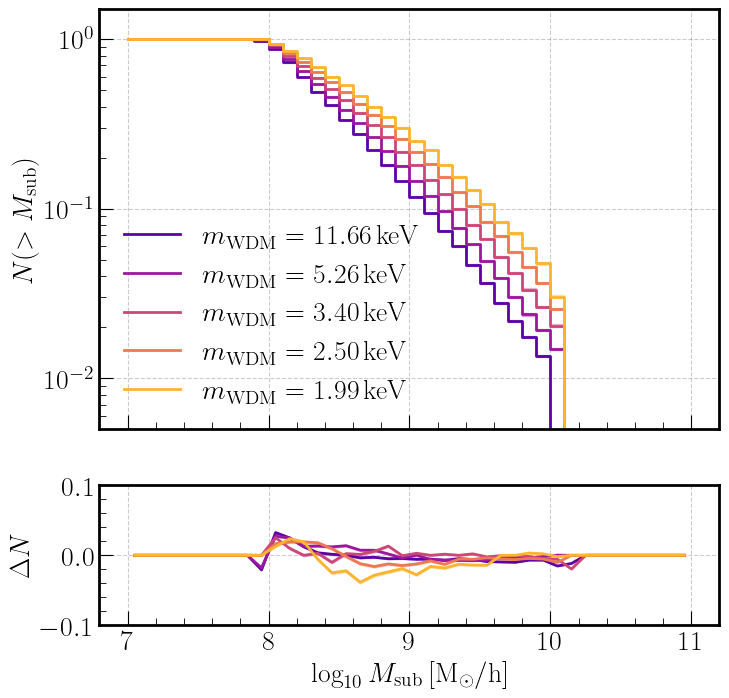

In [86]:
# define the bin for the subhalo mass function
x_bin_size = 0.1
x_plot_range = (7, 11)
x_q = [50, 16, 84]
x_cumulative = True
x_bins = np.arange(x_plot_range[0], x_plot_range[1] + x_bin_size, x_bin_size)
x_num_bins = len(x_bins) - 1
x_bins_center = 0.5 * (x_bins[:-1] + x_bins[1:])
x_bins_plot = np.zeros(2 * x_num_bins)
x_bins_plot[::2] = x_bins[:-1]
x_bins_plot[1::2] = x_bins[1:]

fig, axes = plt.subplots(
    2, 1, figsize=(8, 8), sharex=True, sharey='row', 
    gridspec_kw=dict(height_ratios=[3, 1]))

colors = sns.color_palette('plasma', n_bins_per_dim)

for i in range(n_bins_per_dim):
    label = r'$m_\mathrm{{WDM}} = {{{:.2f}}} \, \mathrm{{keV}}$'.format(
        1/np.mean(cond_bins[i][:, 1]))

    # calculate the median and 1-sigma error bars
    num_samples_bins = gen_samples_bins[i].shape[0]
    gen_x_med, gen_x_low, gen_x_high = get_histogram_q(
        gen_samples_bins[i][..., 6], bins=x_bins, q=x_q, 
        cumulative=True, normalized=True)
    gen_x_err = (gen_x_high - gen_x_low) / np.sqrt(num_samples_bins)
    gen_x_low_std = gen_x_med - gen_x_err
    gen_x_high_std = gen_x_med + gen_x_err

    truth_x_counts = get_histogram_q(
        truth_samples_bins[i][..., 6], bins=x_bins, q=x_q, 
        cumulative=True, normalized=True)
    diff_x_counts = gen_x_med - truth_x_counts[0]

    axes[0].plot(
        x_bins_plot, gen_x_med.repeat(2), lw=2, color=colors[i], 
        label=label)
    axes[0].fill_between(
        x_bins_plot, gen_x_low_std.repeat(2), gen_x_high_std.repeat(2),
        color=colors[i], alpha=0.3)

    axes[1].plot(
        x_bins_center, diff_x_counts, lw=2, color=colors[i])
    axes[1].fill_between(
        x_bins_center, diff_x_counts - gen_x_err, diff_x_counts + gen_x_err,
        color=colors[i], alpha=0.3)


axes[1].set_xlabel(r'$\log_{10} M_\mathrm{sub} \, [\rm M_\odot / h]$')
axes[0].set_ylabel(r'$N(> M_\mathrm{sub})$')
axes[1].set_ylabel(r'$\Delta N$')
axes[0].legend(fontsize=20)
axes[1].set_ylim(-0.1, 0.1)

axes[0].set_yscale('log')
axes[0].set_ylim(5e-3, 1.5)

# fig.subplots_adjust(hspace=0.05, wspace=0.05)
# fig.savefig('figures/msubhalo_mWDM.png', bbox_inches='tight')
# plt.show()

(0.005, 1.5)

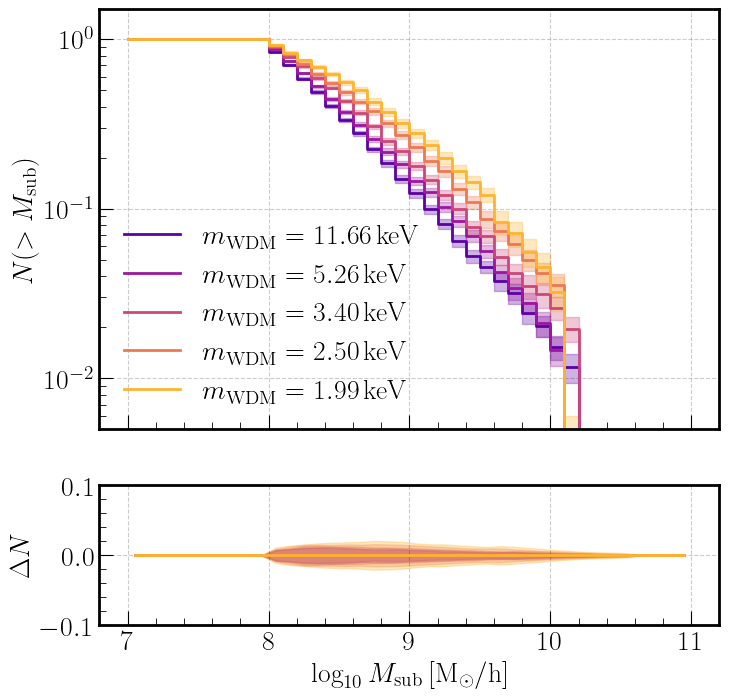

In [87]:
# define the bin for the subhalo mass function
x_bin_size = 0.1
x_plot_range = (7, 11)
x_q = [50, 16, 84]
x_cumulative = True
x_bins = np.arange(x_plot_range[0], x_plot_range[1] + x_bin_size, x_bin_size)
x_num_bins = len(x_bins) - 1
x_bins_center = 0.5 * (x_bins[:-1] + x_bins[1:])
x_bins_plot = np.zeros(2 * x_num_bins)
x_bins_plot[::2] = x_bins[:-1]
x_bins_plot[1::2] = x_bins[1:]

fig, axes = plt.subplots(
    2, 1, figsize=(8, 8), sharex=True, sharey='row', 
    gridspec_kw=dict(height_ratios=[3, 1]))

colors = sns.color_palette('plasma', n_bins_per_dim)

for i in range(n_bins_per_dim):
    label = r'$m_\mathrm{{WDM}} = {{{:.2f}}} \, \mathrm{{keV}}$'.format(
        1/np.mean(cond_bins[i][:, 1]))

    # calculate the median and 1-sigma error bars
    num_samples_bins = truth_samples_bins[i].shape[0]
    gen_x_med, gen_x_low, gen_x_high = get_histogram_q(
        truth_samples_bins[i][..., 6], bins=x_bins, q=x_q, 
        cumulative=True, normalized=True)
    gen_x_err = (gen_x_high - gen_x_low) / np.sqrt(num_samples_bins/100)
    gen_x_low_std = gen_x_med - gen_x_err
    gen_x_high_std = gen_x_med + gen_x_err

    truth_x_counts = get_histogram_q(
        truth_samples_bins[i][..., 6], bins=x_bins, q=x_q, 
        cumulative=True, normalized=True)
    diff_x_counts = gen_x_med - truth_x_counts[0]

    axes[0].plot(
        x_bins_plot, gen_x_med.repeat(2), lw=2, color=colors[i], 
        label=label)
    axes[0].fill_between(
        x_bins_plot, gen_x_low_std.repeat(2), gen_x_high_std.repeat(2),
        color=colors[i], alpha=0.3)

    axes[1].plot(
        x_bins_center, diff_x_counts, lw=2, color=colors[i])
    axes[1].fill_between(
        x_bins_center, diff_x_counts - gen_x_err, diff_x_counts + gen_x_err,
        color=colors[i], alpha=0.3)


axes[1].set_xlabel(r'$\log_{10} M_\mathrm{sub} \, [\rm M_\odot / h]$')

axes[0].set_ylabel(r'$N(> M_\mathrm{sub})$')
axes[1].set_ylabel(r'$\Delta N$')
axes[0].legend(fontsize=20)
axes[1].set_ylim(-0.1, 0.1)
axes[0].set_yscale('log')
axes[0].set_ylim(5e-3, 1.5)

# fig.subplots_adjust(hspace=0.05, wspace=0.05)
# fig.savefig('figures/msubhalo_mWDM.png', bbox_inches='tight')
# plt.show()